In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

In [2]:
start = datetime.datetime(2013, 9, 1)
end = datetime.datetime(2018, 9, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'JNJ', 'MSFT', 'QCOM', 'HPQ', 'TSLA', 'AMZN', 'IBM', 'SPY']

data = yf.download(tickers, start="2013-01-01", end="2018-01-01")
df = data["Adj Close"].dropna(how="all")

df.tail()

[*********************100%%**********************]  11 of 11 completed


,AAPL,ADBE,AMZN,HPQ,IBM,JNJ,MSFT,ORCL,QCOM,SPY,TSLA
Date,,,,,,,,,,,
2017-12-22,41.216583,175.000000,58.417999,17.184307,106.310478,116.421913,79.384453,42.425568,54.028061,239.672668,21.680000
2017-12-26,40.170914,174.440002,58.838001,17.160057,106.540535,116.397011,79.282333,42.488274,53.669144,239.385941,21.152666
2017-12-27,40.177979,175.360001,59.112999,17.192390,106.749619,116.795837,79.570122,42.443474,53.869461,239.502411,20.775999
2017-12-28,40.291023,175.550003,59.305000,17.095396,107.384026,116.787521,79.579376,42.568905,53.735916,239.995239,21.024000
2017-12-29,39.855343,175.240005,58.473499,16.982235,106.951820,116.089539,79.412292,42.353905,53.435436,239.090302,20.756666


In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            #Extract Time Series Data
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            #use coint function to perform cointegration test on 2 time series
            result = coint(S1, S2)
            #tuple containing pvalue
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05: #set the p-value = 0.05
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

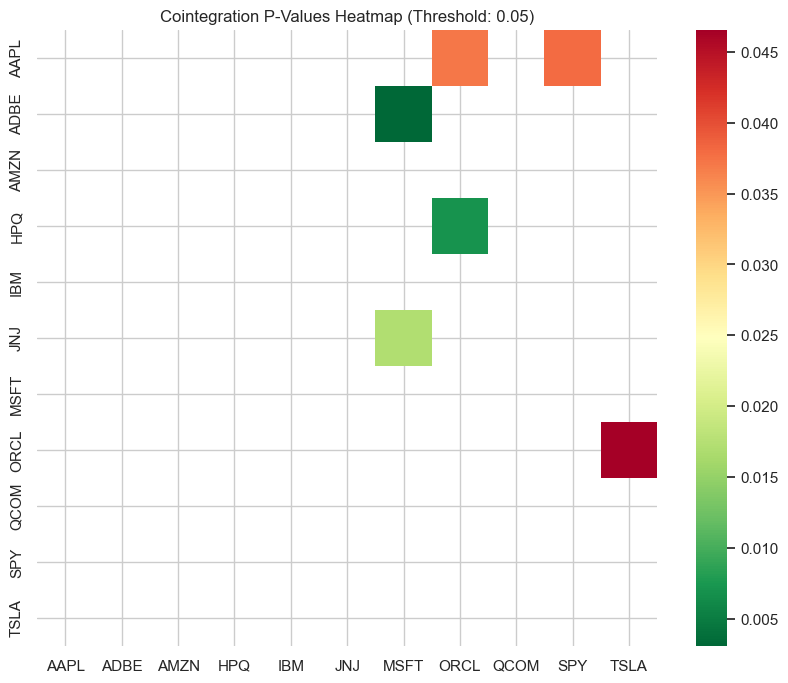

The Cointegrated Pairs are
[('AAPL', 'ORCL'), ('AAPL', 'SPY'), ('ADBE', 'MSFT'), ('HPQ', 'ORCL'), ('JNJ', 'MSFT'), ('ORCL', 'TSLA')]


In [4]:
# Heatmap to show the p-values of the cointegration test between each pair of stocks
pvalues, pairs = find_cointegrated_pairs(df)
threshold = 0.05
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r', mask = (pvalues >= threshold))
plt.title(f'Cointegration P-Values Heatmap (Threshold: {threshold})')
plt.show()
print("The Cointegrated Pairs are")
print(pairs)

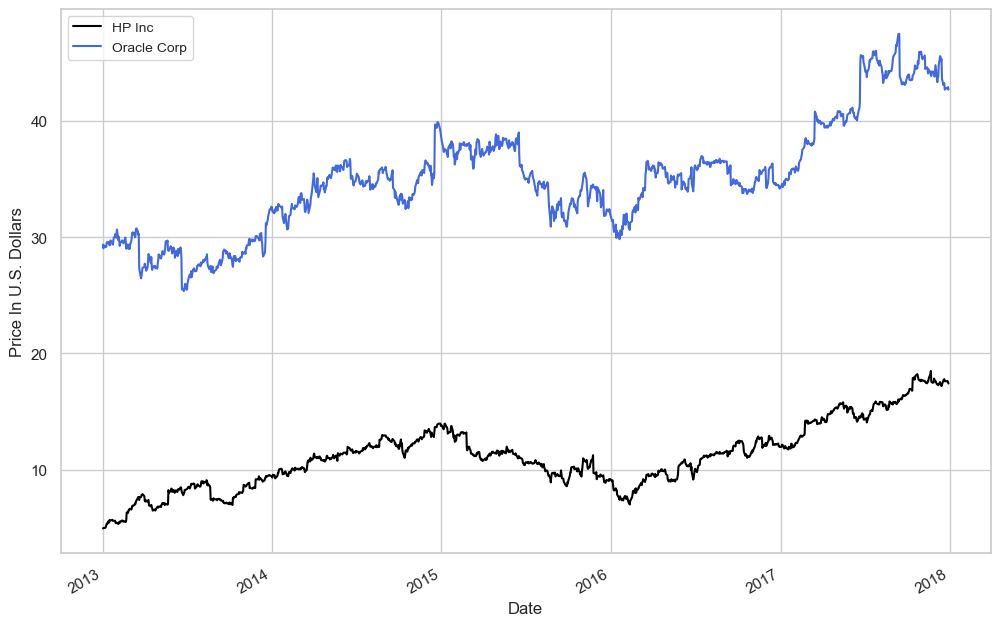

In [5]:
plt.figure(figsize=(12,8))
df['HPQ'].plot(color = 'black')
df['ORCL'].plot(color = 'royalblue')
plt.legend(['HP Inc', 'Oracle Corp'], prop={'size': 10})
plt.ylabel('Price In U.S. Dollars')
plt.show()

In [6]:
#cointegration test
S1 = df['HPQ']
S2 = df['ORCL']

_, pvalue, _ = coint(S1, S2)
pvalue
#low pvalue means high cointegration

0.007053476401588115

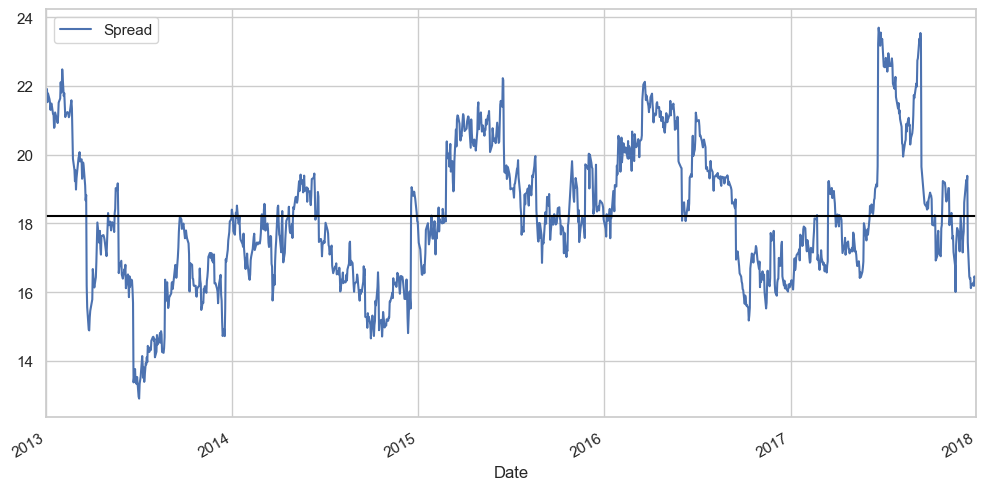

In [7]:
#2 ways to test stationarity
#Method 1: Calculating the Spread, Engle-Granger method

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['HPQ']
coeff = results.params['HPQ']
#Use a linear regression to get the coefficient for the linear combination 

spread = S2 - coeff * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread']);

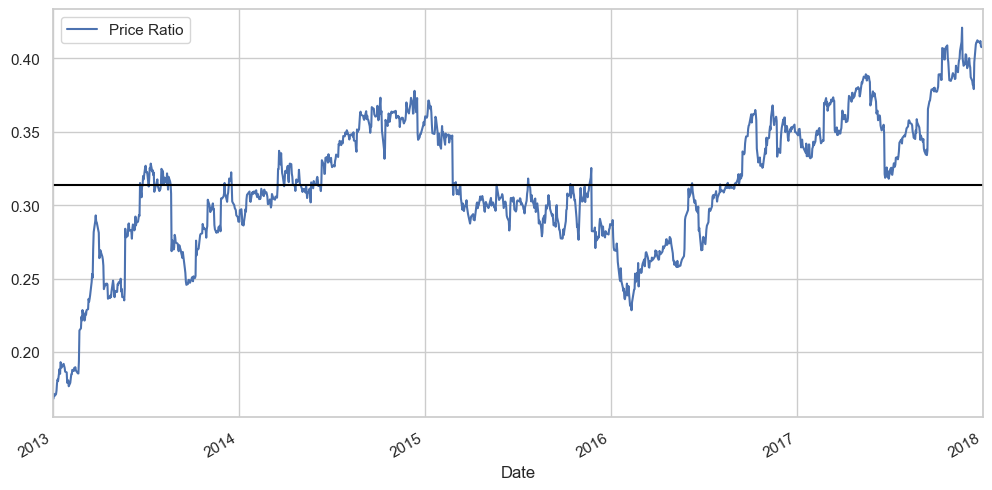

In [8]:
#Method 2: Calculating the price ratio
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio'])
plt.show();

In [9]:
#ADF Test
price_ratio_pvalue = round(adfuller(ratio)[1],5)
spread_pvalue = round(adfuller(spread)[1],5)

(price_ratio_pvalue, spread_pvalue)

(0.0499, 0.00099)

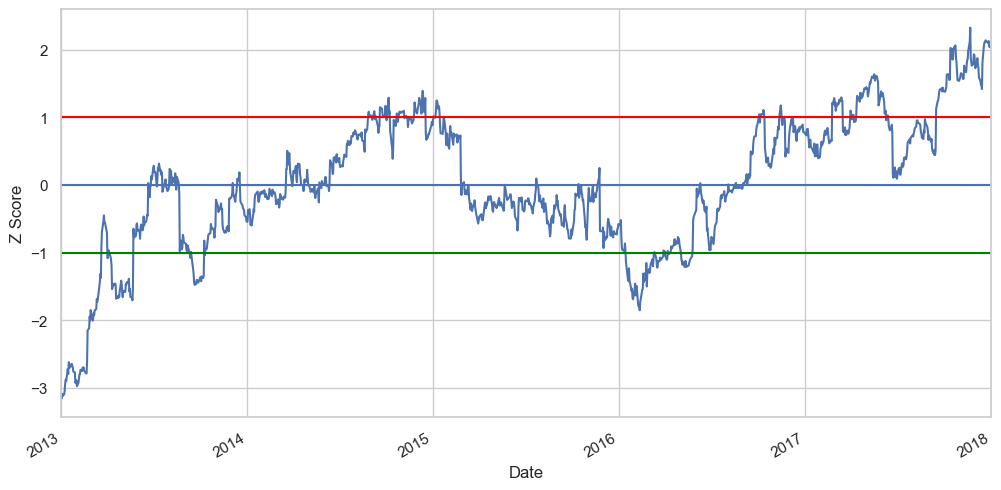

In [10]:
#Normalized Price Ratio
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-09-01', '2018-09-01')
plt.ylabel('Z Score')
plt.show()

In [11]:
#Trading signals

#Train Test Splits

ratios = df['HPQ'] / df['ORCL'] 
print(len(ratios) * .70 ) 

881.3


In [12]:
train = ratios[:881]
test = ratios[881:]

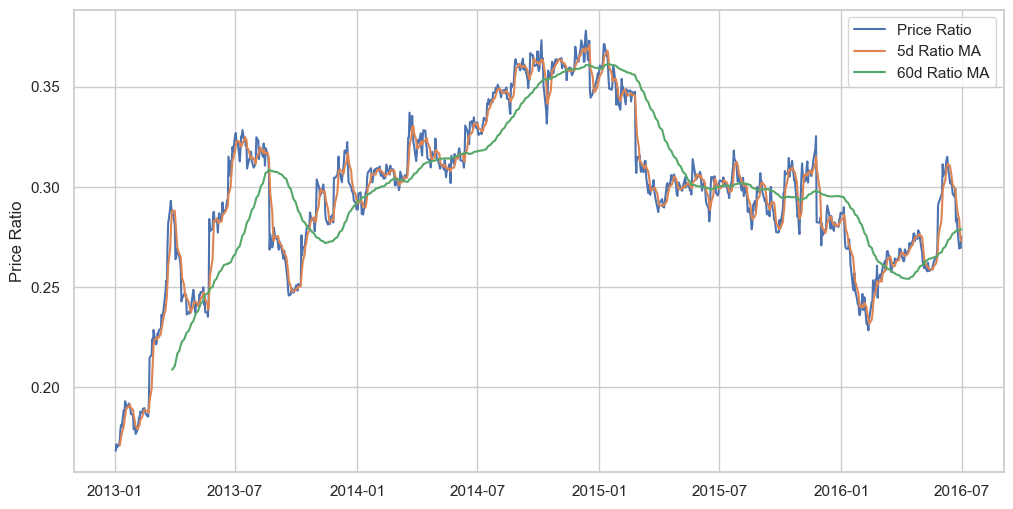

In [13]:
#Mean reversion strategy
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Price Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Price Ratio')
plt.show()

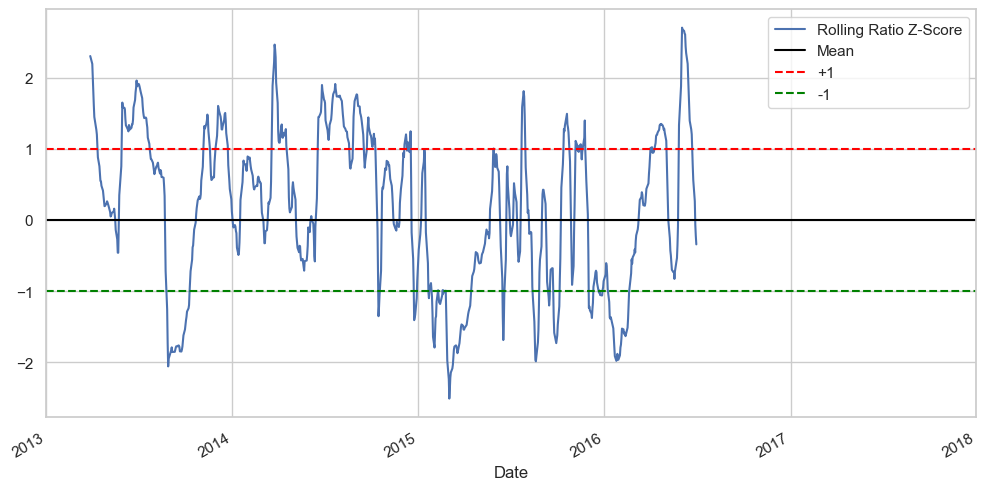

In [14]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-09-01', '2018-09-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio Z-Score', 'Mean', '+1', '-1'])
plt.show()

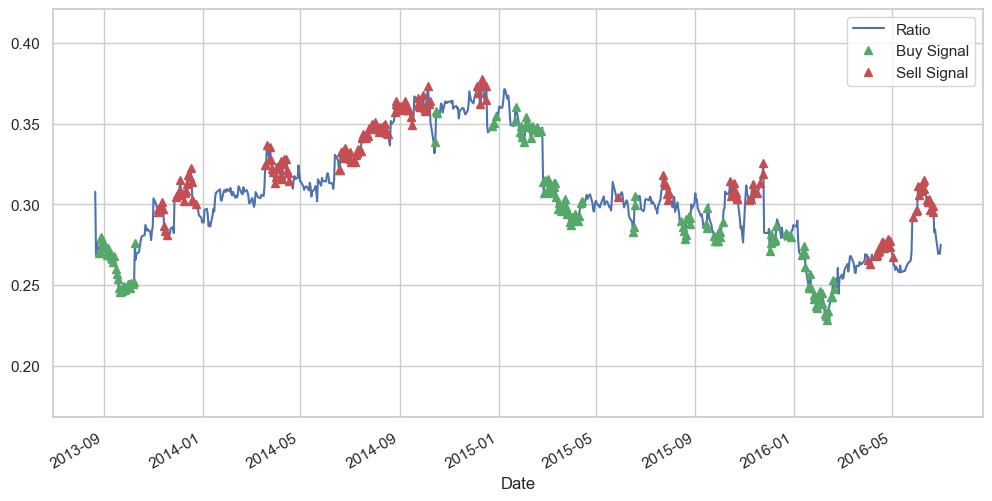

In [34]:
#Creating a model
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0

buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

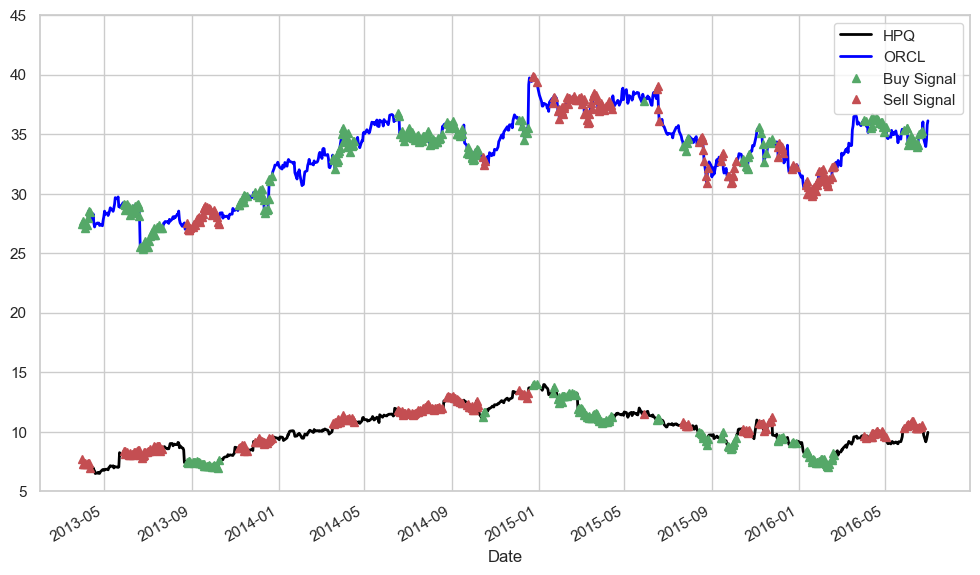

In [45]:
plt.figure(figsize=(12,7))
S1 = df['HPQ'].iloc[:881]
S2 = df['ORCL'].iloc[:881]

S1[60:].plot(color='black',linewidth=2)
S2[60:].plot(color='blue',linewidth=2)
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(5, 45)

plt.legend(['HPQ', 'ORCL', 'Buy Signal', 'Sell Signal'])
plt.show()